In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_38588/1144886652.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)
(1106587, 23)


In [4]:
# Calculate y based on 'product' column
cfpb_df['debt_collection'] = (cfpb_df['Product'] == 'Debt collection').astype(int)

In [5]:
# split dataset train, dev, test
train_df, dev_df, test_df = np.split(cfpb_df[['Consumer complaint narrative','debt_collection']].sample(len(cfpb_df), random_state = 42), 
                                     [int(len(cfpb_df)*0.75), int(len(cfpb_df)*0.9)])

In [6]:
# Load the trained vectorizer
with open('tfidf_vectorizer_999.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

16678

In [7]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 4min 49s


In [8]:
%%time
# Select top 10000 features, 5000 runs faster without significant loss (almost the same)
selector = SelectKBest(chi2, k=10000)
X_train = selector.fit_transform(X_train, y_train)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 342 ms


In [9]:
%%time
# some balancing
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

Wall time: 9min 54s


### Gaussian Naive Bayes

In [10]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
gnb = naive_bayes.GaussianNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        gnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        gnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:25<00:00,  5.38s/it]


In [11]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [06:23<00:00, 35.63it/s]


Train
accuracy_score 0.6817403510824188
balanced_accuracy_score 0.6817403510824188
average_precision_score 0.6120160429764996
              precision    recall  f1-score   support

           0       0.91      0.40      0.56    683885
           1       0.62      0.96      0.75    683885

    accuracy                           0.68   1367770
   macro avg       0.77      0.68      0.65   1367770
weighted avg       0.77      0.68      0.65   1367770



Dev
accuracy_score 0.49557799358989807
balanced_accuracy_score 0.6712181136403564
average_precision_score 0.2474416312849612
              precision    recall  f1-score   support

           0       0.97      0.40      0.57    136701
           1       0.25      0.94      0.40     29287

    accuracy                           0.50    165988
   macro avg       0.61      0.67      0.48    165988
weighted avg       0.84      0.50      0.54    165988

Prediction [(1, 109655), (0, 56333)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 1min 4s


<AxesSubplot:ylabel='Frequency'>

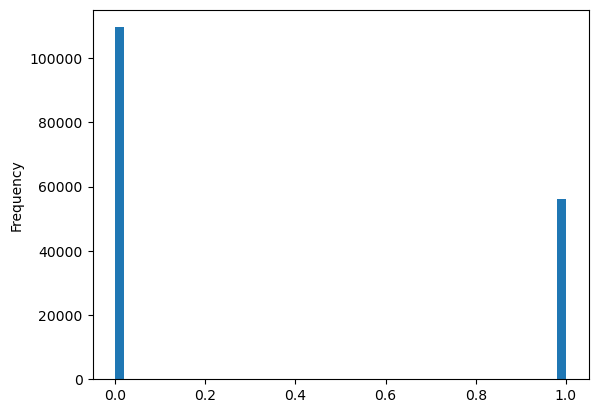

In [12]:
%%time
# development validation
y_pred = gnb.predict(X_dev.toarray())
y_pred_proba = gnb.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_train_res[start:end]

#     # Predict on the batch and append to list
#     batch_pred = gnb.predict(batch_X.A)
#     batch_pred_proba = gnb.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Gaussian Naive Bayes - samll batch size

In [13]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
gnb = naive_bayes.GaussianNB()

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        gnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        gnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [02:29<00:00, 18.32it/s]


In [14]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [06:32<00:00, 34.84it/s]


Train
accuracy_score 0.6816014388384012
balanced_accuracy_score 0.6816014388384012
average_precision_score 0.6119083853672536
              precision    recall  f1-score   support

           0       0.92      0.40      0.56    683885
           1       0.62      0.96      0.75    683885

    accuracy                           0.68   1367770
   macro avg       0.77      0.68      0.65   1367770
weighted avg       0.77      0.68      0.65   1367770



Dev
accuracy_score 0.4953430368460371
balanced_accuracy_score 0.6711022961562405
average_precision_score 0.2473709294223718
              precision    recall  f1-score   support

           0       0.97      0.40      0.57    136701
           1       0.25      0.94      0.40     29287

    accuracy                           0.50    165988
   macro avg       0.61      0.67      0.48    165988
weighted avg       0.84      0.50      0.54    165988

Prediction [(1, 109698), (0, 56290)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 52.6 s


<AxesSubplot:ylabel='Frequency'>

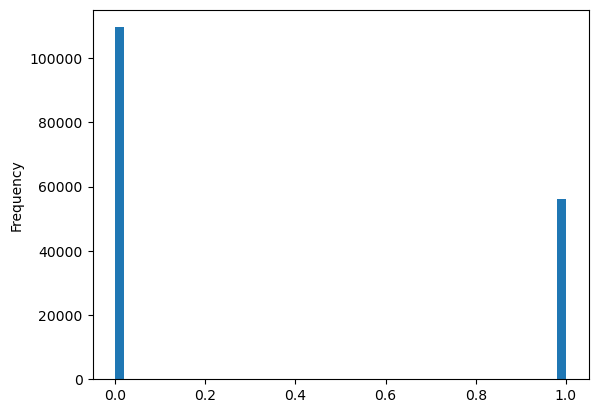

In [15]:
%%time
# development validation
y_pred = gnb.predict(X_dev.toarray())
y_pred_proba = gnb.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_train_res[start:end]

#     # Predict on the batch and append to list
#     batch_pred = gnb.predict(batch_X.A)
#     batch_pred_proba = gnb.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Multinomial Naive Bayes

In [16]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
mnb = naive_bayes.MultinomialNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        mnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        mnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# mnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:05<00:00,  2.44s/it]


In [17]:
# get the results
# y_pred = mnb.predict(X_train_res.toarray())
# y_pred_proba = mnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|███████████████████████████████████████████████████████████████████████████| 13677/13677 [01:54<00:00, 119.05it/s]


Train
accuracy_score 0.8272363043494154
balanced_accuracy_score 0.8272363043494155
average_precision_score 0.7728553964295941
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    683885
           1       0.83      0.82      0.83    683885

    accuracy                           0.83   1367770
   macro avg       0.83      0.83      0.83   1367770
weighted avg       0.83      0.83      0.83   1367770



Dev
accuracy_score 0.833349398751717
balanced_accuracy_score 0.8244513080670677
average_precision_score 0.45311334930402214
              precision    recall  f1-score   support

           0       0.95      0.84      0.89    136701
           1       0.52      0.81      0.63     29287

    accuracy                           0.83    165988
   macro avg       0.74      0.82      0.76    165988
weighted avg       0.88      0.83      0.85    165988

Prediction [(0, 120127), (1, 45861)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 12.5 s


<AxesSubplot:ylabel='Frequency'>

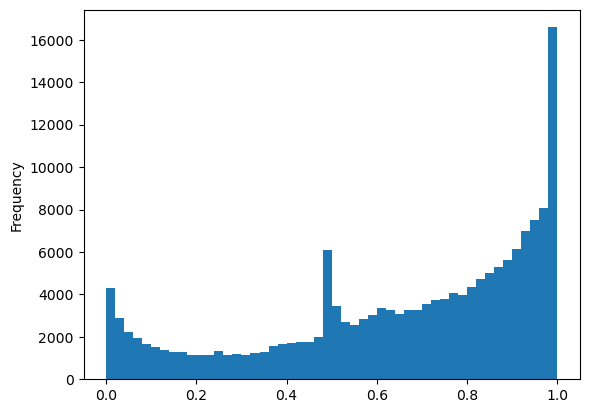

In [18]:
%%time
# development validation
y_pred = mnb.predict(X_dev.toarray())
y_pred_proba = mnb.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Multinomial Naive Bayes  smaller batch size

In [19]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
mnb = naive_bayes.MultinomialNB()

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        mnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        mnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# mnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [01:03<00:00, 42.91it/s]


In [20]:
# get the results
# y_pred = mnb.predict(X_train_res.toarray())
# y_pred_proba = mnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|███████████████████████████████████████████████████████████████████████████| 13677/13677 [01:50<00:00, 124.03it/s]


Train
accuracy_score 0.8287467922238388
balanced_accuracy_score 0.8287467922238387
average_precision_score 0.7802009637990892
              precision    recall  f1-score   support

           0       0.81      0.86      0.83    683885
           1       0.85      0.80      0.82    683885

    accuracy                           0.83   1367770
   macro avg       0.83      0.83      0.83   1367770
weighted avg       0.83      0.83      0.83   1367770



Dev
accuracy_score 0.8504048485432681
balanced_accuracy_score 0.8264888456695777
average_precision_score 0.47399402619332986
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    136701
           1       0.55      0.79      0.65     29287

    accuracy                           0.85    165988
   macro avg       0.75      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 124198), (1, 41790)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 12.4 s


<AxesSubplot:ylabel='Frequency'>

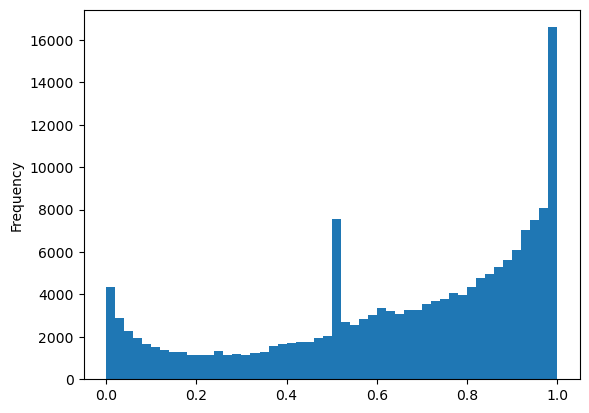

In [21]:
%%time
# development validation
y_pred = mnb.predict(X_dev.toarray())
y_pred_proba = mnb.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)